In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import KFold, RandomizedSearchCV,GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor, Pool
import catboost

import lightgbm as lgb
from lightgbm import Dataset, LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")

from typing import Union

RANDOM_STATE = 42
ModelType = Union[CatBoostRegressor, LGBMRegressor, XGBRegressor]

### Вспомогательные функции

In [2]:

def print_basic_info(df, verbose=False):
    print("train shape", train.shape)
    print("test shape", test.shape, "\n")

    if verbose:
        print("Basic info on the dataset:")
        print(df.info())
        print()
        
    print("Unique values in each column:")
    unique_values = df.nunique().sort_values(ascending=False)
    for col, count in unique_values.items():
        print(f"{col}: {count}")

    print("Possible category columns:", df.select_dtypes(include=['object']).columns.tolist())
    print()

    if verbose:
        for col in df.select_dtypes(include=['object']).columns:
            print(f"{col}: {df[col].unique()}")
        print("Na percent in each column:")
        for col in df.columns:
            print(f"{col}: {df[col].isna().mean() * 100:.2f}%")

def plot_distributions(train, cat_features, num_features, target='target_reg'):
    n_cols = int(np.ceil(len(num_features) / 2))

    # plot features distribution
    axes = train[num_features].hist(figsize=(n_cols * 5, 8), layout=(-1, 5), bins=30, xlabelsize=10)
    for ax in axes.flatten():
        if ax.get_title():
            ax.set_title(ax.get_title(), fontsize=12)
    plt.tight_layout()
    plt.show()

    # plot box plots for numeric
    fig, ax = plt.subplots(2, n_cols, figsize=(n_cols * 6, 8))  # Adjusted figsize
    for i, col in enumerate(num_features):
        row, col_idx = i // n_cols, i % n_cols
        sns.boxplot(x=train[col], ax=ax[row, col_idx])
        ax[row, col_idx].set_xlabel('', fontsize=12)
        ax[row, col_idx].set_title(col, fontsize=12)

    # plot correlation matrix
    corr = train[num_features  + [target]].corr()
    plt.figure(figsize=(10, 5))
    hm = sns.heatmap(
        corr, annot=True, fmt=".2f", cmap="Blues", square=True,
        cbar_kws={"fraction": 0.01},
        linewidth=0.5,
    )
    hm.set_xticklabels(hm.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=8);
    plt.title("Correlation matrix")

    # plot boxplot for categorical features
    fig, ax = plt.subplots(1, len(cat_features), figsize=(15, 3))
    for i, col in enumerate(cat_features):
        sns.boxplot(x=train[col], y=train['target_reg'], ax=ax[i])
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, horizontalalignment="right", fontsize=8);


### Вспомогательные функции для обучения

In [3]:
from training import train_model
from hp_tunning import train_catboost_hp, train_lightgbm_hp, train_xgboost_hp

# Задача 

## Загрузка данных

In [4]:
train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv')

In [5]:
print_basic_info(train)

train shape (2337, 17)
test shape (1913, 16) 

Unique values in each column:
car_id: 2337
user_ride_quality_median: 2337
distance_sum: 2337
riders: 2306
mean_rating: 2223
speed_max: 1938
target_reg: 1835
car_rating: 269
rating_min: 91
user_uniq: 30
model: 26
year_to_work: 9
target_class: 9
year_to_start: 7
car_type: 4
fuel_type: 2
deviation_normal_count: 1
Possible category columns: ['car_id', 'model', 'car_type', 'fuel_type', 'target_class']



Поскольку в `deviation_normal_count` только одно уникальное значение, отбросим этот признак.

In [6]:
results = []  # Здесь будем хранить информацию по каждой модели

cat_features = ['user_uniq', 'model', 'car_type', 'fuel_type']
targets = ['target_reg', 'target_class']
features2drop = ['car_id', 'deviation_normal_count']

filtered_features = [f for f in train.columns if f not in targets + features2drop]
num_features = [f for f in filtered_features if f not in cat_features]


print("cat_features", cat_features)
print("num_features", num_features)
print("targets", targets)

X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]

cat_features ['user_uniq', 'model', 'car_type', 'fuel_type']
num_features ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median']
targets ['target_reg', 'target_class']


In [7]:
X_test = test[filtered_features]

#### Создадим датасет для lightgbm, xgboost

In [8]:
X_encoded = X.copy()
X_test_encoded = X_test.copy()

def transform_category_features(X, X_test):
    le = LabelEncoder()
    for col in cat_features:
        unique = X[col].unique()
        mode = X[col].mode()[0]
        X_test[col] = X_test[col].apply(lambda x: x if x in unique else mode)
    
        X[col] = le.fit_transform(X[col])
        X_test[col] = le.transform(X_test[col])
transform_category_features(X_encoded, X_test_encoded)


for col in cat_features:
    X_encoded[col] = X_encoded[col].astype('category')
    X_test_encoded[col] = X_test_encoded[col].astype('category')

## Графики

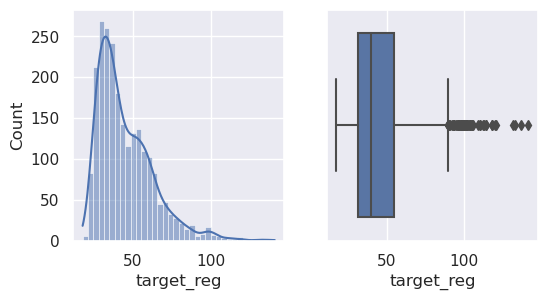

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.histplot(train['target_reg'], kde=True, ax=ax[0])
sns.boxplot(x=train['target_reg'], ax=ax[1])
plt.show()

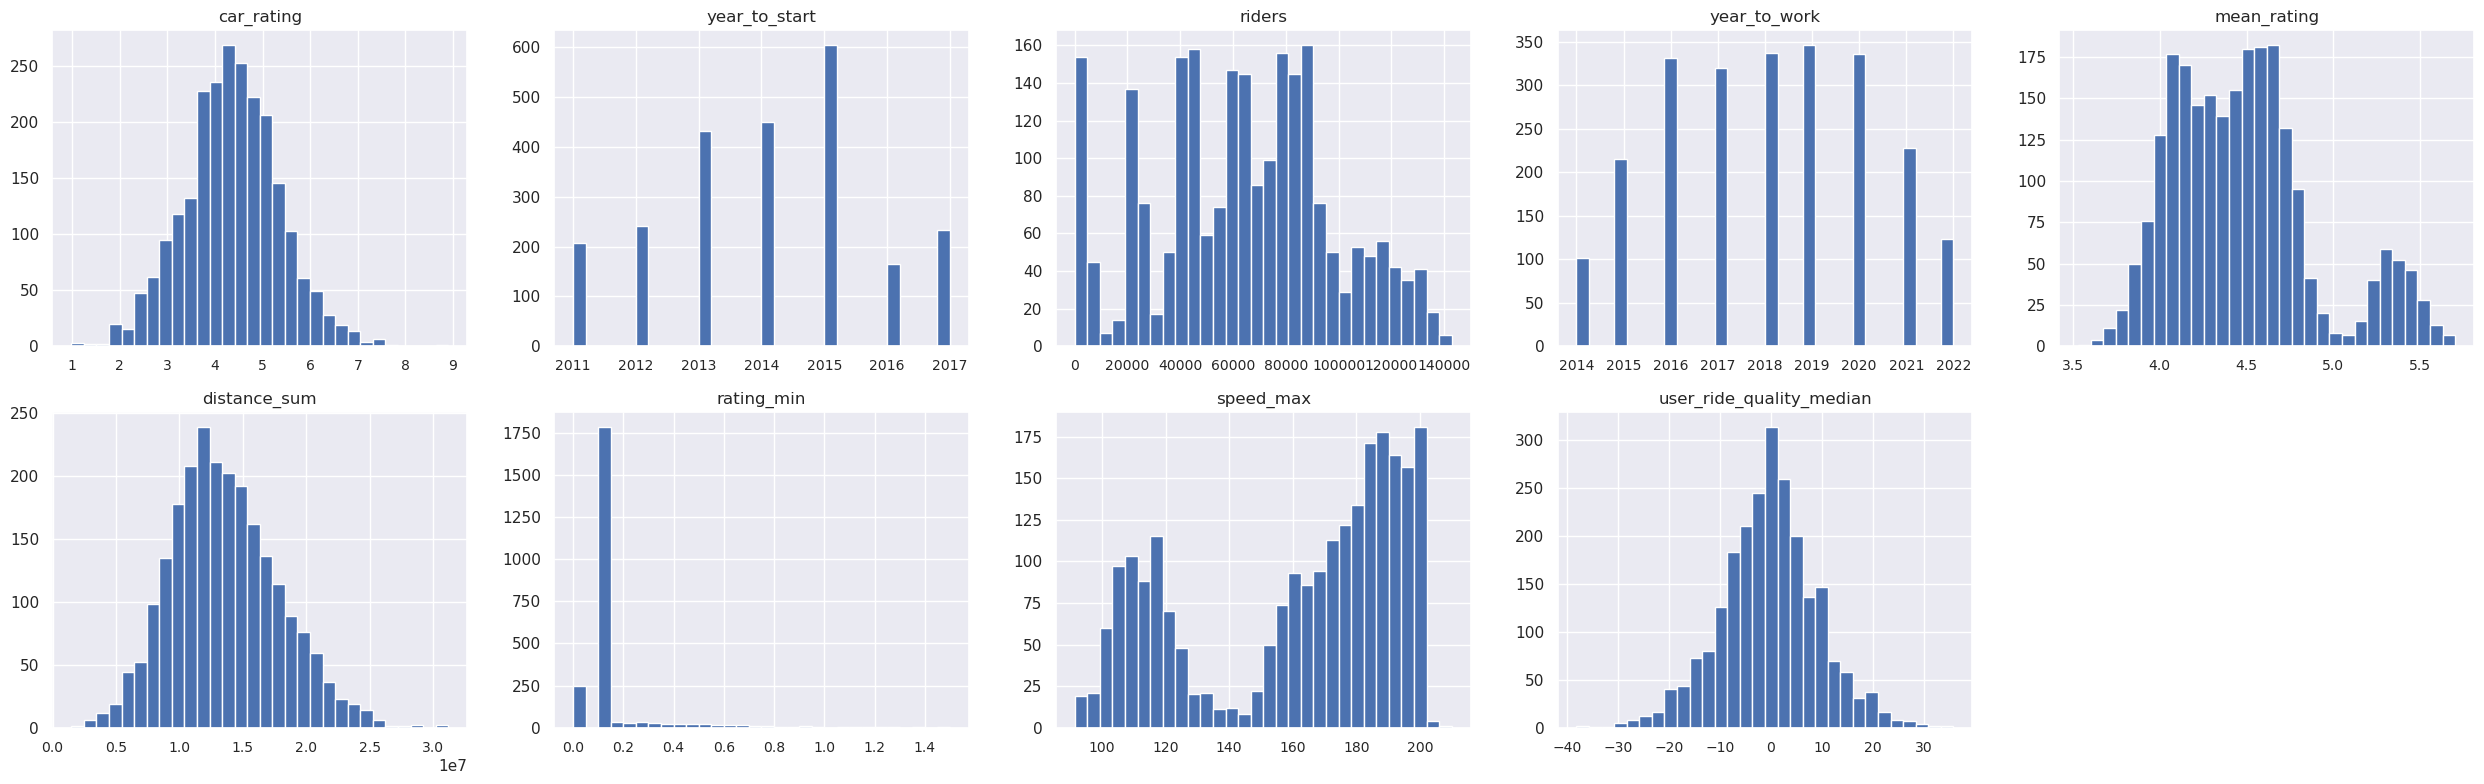

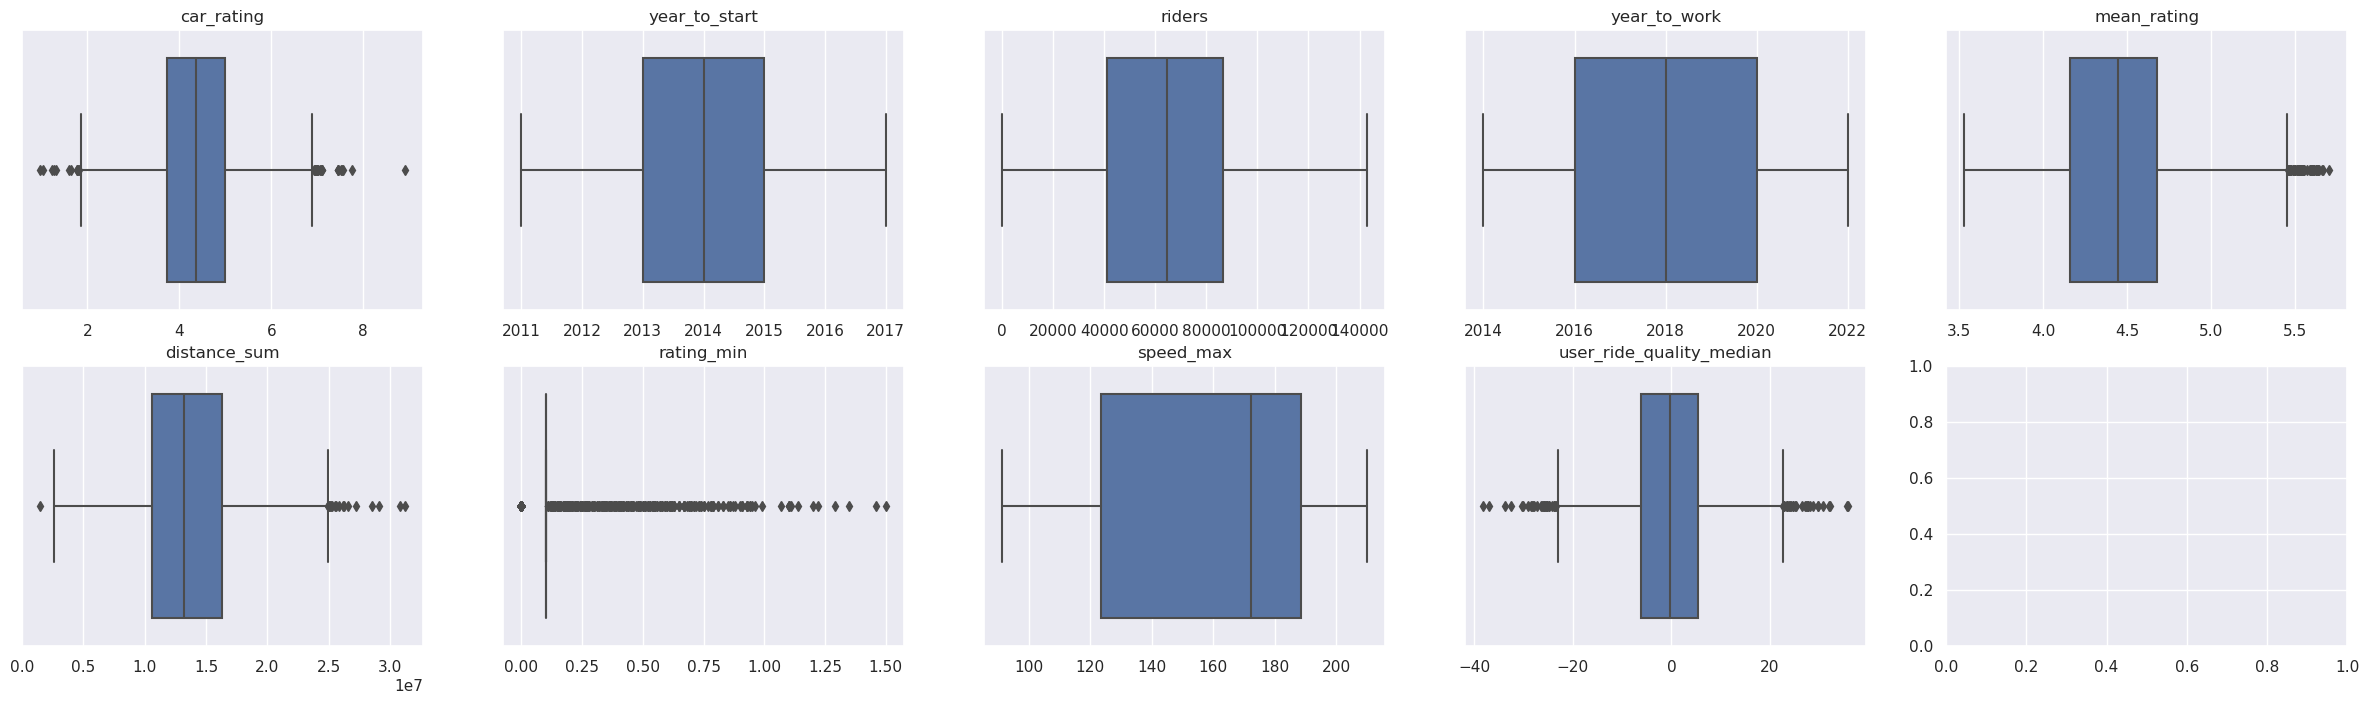

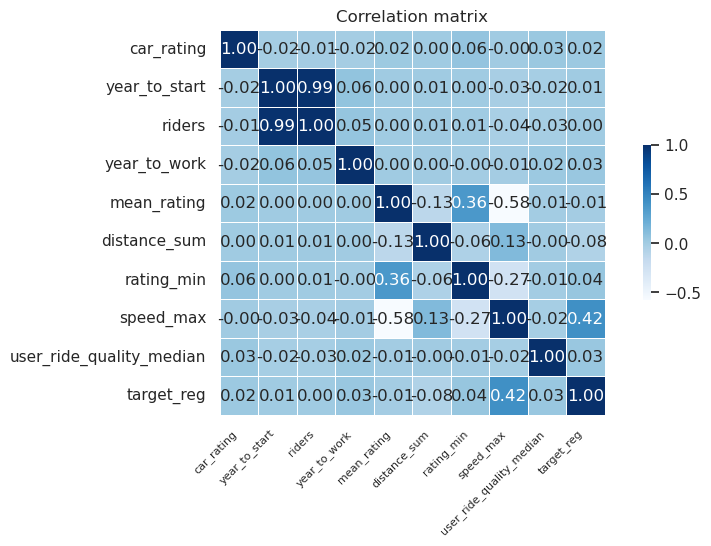

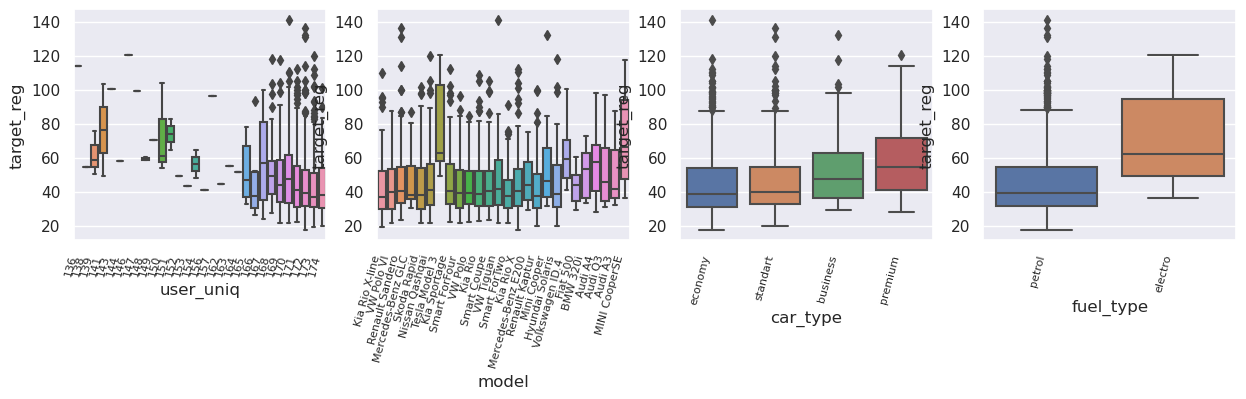

In [10]:
plot_distributions(train, cat_features, num_features)

* Сильно скореллированные признаки - `year_to_start`, `rides`. Можно избавиться от одного, чтобы получть большую устойчивость и интерпретируемость модели
* У большинства численных признаков распределение приближенное к нормальному, нет выбросов или очень длинных хвостов (кроме `rating_min`).
* Все категориальные признаки показывают влияние на трагет.
* Распределение таргета скошенное, без длинного хвоста.

# Обучение

## Catboost

### Baseline

In [11]:
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE
}

cb_score, mean_kfold_score, std_score, cb_model = train_model(
    algorithm=CatBoostRegressor,
    X=X, y=y,
    init_params=cb_init_params,
    early_stopping_rounds=20,
    cat_features=cat_features,
    random_seed=RANDOM_STATE,
    verbose=False
)

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.88
FOLD 1: SCORE 11.89
FOLD 2: SCORE 11.35
Mean RMSE score: 11.71 +-0.25 



In [12]:
cb_test_pred = cb_model.predict(X_test)
pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('subs/cb_pred.csv', index=False)

In [13]:
results.append({
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'model_name': 'CatBoostRegressor',
    'tuning': False,
    'kfold_score': cb_score,
    'mean_kfold_score': mean_kfold_score,
    'std_score': std_score,
    'leaderboard_score': 12,
    'model': cb_model
})

### Randomized hp search

Выбрали nested схему для нахождения лучших гиперпараметров:

- for 3 folds:
    - run randomized cv hp seach
 
Получив 3 набора гипер параметров и обучив на этих наборах 3 модели на всем трейн части фолда, получаем оценки на валидации.

In [14]:
%%time

init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE,
    'iterations': 500,
    'early_stopping_rounds': 20,
    'logging_level': 'Silent',
}

params = {
    'depth': [4, 5, 6],
    'l2_leaf_reg': [0.5, 0.7, 1, 3],
    'min_data_in_leaf': [3, 5, 7, 11],
    # 'one_hot_max_size': [2, 3],
    # 'max_ctr_complexity': [2, 3],
    # 'colsample_bylevel': [0.8, 0.9, 1],
    # 'boosting_type': ['Ordered', 'Plain'],
    # 'bootstrap_type': [ 'Bernoulli', 'MVS', 'No' ],
}

cb_hp_score, mean_kfold_score, std_score, cb_hp_model = train_catboost_hp(
    X, y, params=params, init_params=init_params, cat_features=cat_features, verbose=False, plot=False,
    n_iter=10, cv=3, 
)

BEST PARAMS for split 0:
 {'min_data_in_leaf': 11, 'depth': 5, 'l2_leaf_reg': 0.5}
SCORE val/train: 12.01/9.26 

BEST PARAMS for split 1:
 {'min_data_in_leaf': 7, 'depth': 4, 'l2_leaf_reg': 0.5}
SCORE val/train: 11.85/10.04 

BEST PARAMS for split 2:
 {'min_data_in_leaf': 7, 'depth': 4, 'l2_leaf_reg': 3}
SCORE val/train: 11.41/10.51 

MEAN RMSE score: 11.75 +-0.26 

BEST MODEL: {'min_data_in_leaf': 7, 'depth': 4, 'l2_leaf_reg': 3}
BEST RMSE: 11.41 

CPU times: user 8min 25s, sys: 33.2 s, total: 8min 58s
Wall time: 35.3 s


In [15]:
cb_test_pred = cb_hp_model.predict(X_test)
pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('subs/cb_hp_pred.csv', index=False)

In [16]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': True,
    'kfold_score': cb_hp_score,
    'mean_kfold_score': mean_kfold_score,
    'std_score': std_score,
    'leaderboard_score': 11.9,
    'model': cb_hp_model,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
})

### Feature importance

In [17]:
train_dataset = Pool(data=X, label=y, cat_features=cat_features)

feature_importances = cb_hp_model.get_feature_importance(data=train_dataset, type=catboost.EFstrType.PredictionValuesChange)
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
feature_importances_df

,Feature,Importance
10,speed_max,44.967604
7,mean_rating,28.088688
9,rating_min,10.403804
1,car_type,3.305970
2,fuel_type,2.623298
5,riders,2.173988
12,user_uniq,1.891369
8,distance_sum,1.746521
11,user_ride_quality_median,1.690573
3,car_rating,1.182399


### Feature selection

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = ['model', 'car_type', 'fuel_type']

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

selected_features_catboost = cb_hp_model.select_features(
    train_pool,
    eval_set=val_pool,
    algorithm='RecursiveByShapValues',
    features_for_select=X_train.columns,
    num_features_to_select=10,
    steps=5,
    train_final_model=False,
    logging_level='Silent'
)['selected_features_names']

The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


In [19]:
selected_features_catboost

['model',
 'car_type',
 'fuel_type',
 'car_rating',
 'year_to_work',
 'mean_rating',
 'distance_sum',
 'rating_min',
 'speed_max',
 'user_uniq']

Для отобранных признаков получим две модели:
- на дефолтных параметрах обученную на "лучшем" фолде в CV режиме
- подберем гиперпараметры с помощью RandomizedSearch

Лучшую модель добавим к статистке.

In [20]:
%%time

cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE,
    'min_data_in_leaf': 7, 'depth': 4, 'l2_leaf_reg': 3,
}

print("Running CV..")

cb_fs_score, mean_kfold_fs_score, std_fs_score, cb_fs_model = train_model(
    algorithm=CatBoostRegressor,
    X=X[selected_features_catboost], y=y,
    init_params=cb_init_params,
    early_stopping_rounds=20,
    cat_features=[c for c in cat_features if c in selected_features_catboost],
    random_seed=RANDOM_STATE,
    verbose=False
)

print("Running HP search..")

init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE,
    'iterations': 500,
    'early_stopping_rounds': 20,
    'logging_level': 'Silent',
}

params = {
    'depth': [4, 5, 6],
    'l2_leaf_reg': [0.5, 0.7, 1, 3],
    'min_data_in_leaf': [3, 5, 7, 11],
}

cb_hp_score, mean_kfold_score, std_score, cb_hp_model = train_catboost_hp(
    X[selected_features_catboost], y, 
    params=params, 
    init_params=init_params, 
    cat_features=[c for c in cat_features if c in selected_features_catboost],
    verbose=False, 
    plot=False,
    n_iter=10, cv=3, 
)

Running CV..
========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.88
FOLD 1: SCORE 11.72
FOLD 2: SCORE 11.38
Mean RMSE score: 11.66 +-0.21 

Running HP search..
BEST PARAMS for split 0:
 {'min_data_in_leaf': 5, 'depth': 4, 'l2_leaf_reg': 0.7}
SCORE val/train: 11.91/10.02 

BEST PARAMS for split 1:
 {'min_data_in_leaf': 5, 'depth': 4, 'l2_leaf_reg': 0.7}
SCORE val/train: 11.71/10.23 

BEST PARAMS for split 2:
 {'min_data_in_leaf': 5, 'depth': 4, 'l2_leaf_reg': 0.7}
SCORE val/train: 11.41/10.58 

MEAN RMSE score: 11.68 +-0.21 

BEST MODEL: {'min_data_in_leaf': 5, 'depth': 4, 'l2_leaf_reg': 0.7}
BEST RMSE: 11.41 

CPU times: user 12min 33s, sys: 51.7 s, total: 13min 24s
Wall time: 54.7 s


In [21]:
cb_test_pred = cb_fs_model.predict(X_test)
pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('subs/cb_fs_pred.csv', index=False)

In [22]:
results.append({
    'model_name': 'CatBoostRegressor (Feature Selection)',
    'tuning': False,
    'kfold_score': cb_fs_score,
    'mean_kfold_score': mean_kfold_fs_score,
    'std_score': std_fs_score,
    'leaderboard_score': 11.9,
    'model': cb_fs_model,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
})

## Lightgbm

### Baseline

In [23]:
lgb_init_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'goss',
    'verbosity': -1,
    'seed': RANDOM_STATE
}

lgb_score, mean_kfold_score, std_score, lgb_model = train_model(
    algorithm=LGBMRegressor,
    X=X_encoded, y=y,
    init_params=lgb_init_params,
    early_stopping_rounds=25,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING LGBMRegressor =========
FOLD 0: SCORE 12.33
FOLD 1: SCORE 12.59
FOLD 2: SCORE 12.00
Mean RMSE score: 12.31 +-0.24 



In [24]:
lgb_test_pred = lgb_model.predict(X_test_encoded)
pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('subs/lgb_pred.csv', index=False)

In [25]:
results.append({
    'model_name': 'LGBMRegressor (goss)',
    'tuning': False,
    'kfold_score': lgb_score,
    'mean_kfold_score': mean_kfold_score,
    'std_score': std_score,
    'leaderboard_score': 12.6,
    'model': lgb_model,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
})

### Randomized hp search

In [26]:
%%time
lgb_init_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'data_sample_strategy':'goss',
    'verbosity': -1,  # -1 for suppression
    'seed': RANDOM_STATE,
    'num_iterations': 50,
}

lgb_fit_params = {
    'eval_metric': 'rmse',
    'categorical_feature': cat_features
}

lgb_grid_params = {
    'reg_alpha': [0.5, 0.75, 1],
    'num_leaves': [4, 5, 6, 7],
    'max_bin': [40, 50, ],
    'num_iterations': [100],
    'min_child_samples': [10, 11, 12, 15],
}

lgb_tuning_score, mean_kfold_score, std_score, lgb_tuning_model = train_lightgbm_hp(
    X_encoded, y, lgb_init_params, lgb_grid_params, lgb_fit_params,  cat_features,
    n_iter=50,
    cv=3,
    verbose=0,
    random_seed=RANDOM_STATE
)

BEST PARAMS for split 0: {'objective': 'regression', 'metric': 'rmse', 'data_sample_strategy': 'goss', 'verbosity': -1, 'seed': 42, 'num_iterations': 100, 'reg_alpha': 0.5, 'num_leaves': 5, 'min_child_samples': 10, 'max_bin': 40}
SCORE val/train: 11.81/10.18, 
BEST PARAMS for split 1: {'objective': 'regression', 'metric': 'rmse', 'data_sample_strategy': 'goss', 'verbosity': -1, 'seed': 42, 'num_iterations': 100, 'reg_alpha': 0.5, 'num_leaves': 5, 'min_child_samples': 15, 'max_bin': 40}
SCORE val/train: 11.86/10.34, 
BEST PARAMS for split 2: {'objective': 'regression', 'metric': 'rmse', 'data_sample_strategy': 'goss', 'verbosity': -1, 'seed': 42, 'num_iterations': 100, 'reg_alpha': 1, 'num_leaves': 5, 'min_child_samples': 12, 'max_bin': 50}
SCORE val/train: 11.41/10.54, 
MEAN RMSE score: 11.69 +-0.20 

BEST MODEL: {'objective': 'regression', 'metric': 'rmse', 'data_sample_strategy': 'goss', 'verbosity': -1, 'seed': 42, 'num_iterations': 100, 'reg_alpha': 1, 'num_leaves': 5, 'min_child_s

In [27]:
lgb_test_pred = lgb_tuning_model.predict(X_test_encoded)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('subs/lgb_pred_hp.csv', index=False)

In [28]:
results.append({
    'model_name': 'LGBMRegressor (goss)',
    'tuning': True,
    'kfold_score': lgb_tuning_score,
    'mean_kfold_score': mean_kfold_score,
    'std_score': std_score,
    'leaderboard_score': 12,
    'model': lgb_tuning_model,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
})

## XGBoost

### Baseline

In [29]:
xgb_init_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0,
    'seed': RANDOM_STATE,
    'enable_categorical': True
}

xgb_score, mean_kfold_score, std_score, xgb_model = train_model(
    algorithm=XGBRegressor,
    X=X_encoded, y=y,
    init_params=xgb_init_params,
    early_stopping_rounds=20,
    cat_features=cat_features,
    random_seed=RANDOM_STATE,
    verbose=True
)

========= TRAINING XGBRegressor =========
[0]	dtrain-rmse:14.69765	dtest-rmse:14.90796
[9]	dtrain-rmse:7.79691	dtest-rmse:12.32130
FOLD 0: SCORE 12.27
[0]	dtrain-rmse:14.28030	dtest-rmse:15.91563
[9]	dtrain-rmse:7.83840	dtest-rmse:12.70617
FOLD 1: SCORE 12.63
[0]	dtrain-rmse:14.78788	dtest-rmse:14.90920
[9]	dtrain-rmse:8.30839	dtest-rmse:12.35903
FOLD 2: SCORE 12.26
Mean RMSE score: 12.38 +-0.17 



In [30]:
X_test_dmatrix = xgb.DMatrix(X_test_encoded, enable_categorical=True)
xgb_test_pred = xgb_model.predict(X_test_dmatrix)
pd.DataFrame({'car_id': test['car_id'], 'target_reg': xgb_test_pred}).to_csv('subs/xgb_pred.csv', index=False)

In [31]:
results.append({
    'model_name': 'XGBRegressor (dart)',
    'tuning': False,
    'kfold_score': xgb_score,
    'mean_kfold_score': mean_kfold_score,
    'std_score': std_score,
    'leaderboard_score': 12.3,
    'model': xgb_model,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
})

### Randomized hp search

In [32]:
%%time

xgb_init_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0,  # 0 (silent), 1 (warning), 2 (info), 3 (debug)
    'seed': RANDOM_STATE,
    'enable_categorical': True,
    'nthread': -1
}

grid_params = {
    'num_boost_round': [50],
    'max_depth': [3, 5, 6,],
    'max_leaves': [7, 9, 11, 15],
    'min_child_weight': [12, 14, 16, 18],
    'lambda': [0.05, 0.1, 1, 5, 10, 12],
    'rate_drop': [0.05, 0.1, 0.25, 0.3],
    'one_drop': [0, 1],
    'skip_drop': [0.1, 0.25, 0.3, 0.5],
    'booster': ['dart'],
    'eta': [0.1, 0.15, 0.2, 0.25,],
}

# learning_rates = np.linspace(0.3, 0.005, 50).tolist()
# scheduler = xgb.callback.LearningRateScheduler(learning_rates)
# fit_params = dict(callbacks=[scheduler])

xgb_tuning_score, mean_kfold_score, std_score, xgb_tuning_model = train_xgboost_hp(
        X_encoded, y, xgb_init_params, grid_params, {}, cat_features,
        n_iter=10,
        cv=3,
        verbose=False,
        random_seed=RANDOM_STATE,
        n_jobs=1
)

TRAINING FINAL 0 FOLD MODEL..
[0]	validation-rmse:16.32768
[10]	validation-rmse:12.66862
[20]	validation-rmse:12.11981
[30]	validation-rmse:11.96478
[40]	validation-rmse:11.91532
[49]	validation-rmse:11.94256
BEST ITER: 40
BEST PARAMS for split 0:
 {'skip_drop': 0.25, 'rate_drop': 0.05, 'one_drop': 0, 'num_boost_round': 50, 'min_child_weight': 12, 'max_leaves': 15, 'max_depth': 5, 'lambda': 0.1, 'eta': 0.1, 'booster': 'dart'}
SCORE val/train: 11.91/10.13

TRAINING FINAL 1 FOLD MODEL..
[0]	validation-rmse:17.36519
[10]	validation-rmse:13.64044
[20]	validation-rmse:12.71042
[30]	validation-rmse:12.50189
[40]	validation-rmse:12.23613
[50]	validation-rmse:12.14017
[60]	validation-rmse:12.11005
[70]	validation-rmse:12.01366
[80]	validation-rmse:12.00973
[83]	validation-rmse:12.01776
BEST ITER: 73
BEST PARAMS for split 1:
 {'skip_drop': 0.1, 'rate_drop': 0.1, 'one_drop': 1, 'num_boost_round': 50, 'min_child_weight': 12, 'max_leaves': 7, 'max_depth': 5, 'lambda': 0.1, 'eta': 0.15, 'booster': 

In [33]:
X_test_dmatrix = xgb.DMatrix(X_test_encoded, enable_categorical=True)
tuning_test_pred = xgb_tuning_model.predict(X_test_dmatrix, iteration_range=(0, xgb_tuning_model.best_iteration + 1))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': tuning_test_pred}).to_csv('subs/xgb_pred_hp.csv', index=False)

In [34]:
results.append({
    'model_name': 'XGBRegressor (dart)',
    'tuning': True,
    'kfold_score': xgb_tuning_score,
    'mean_kfold_score': mean_kfold_score,
    'std_score': std_score,
    'leaderboard_score': 12.1,
    'model': xgb_tuning_model,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
})

## Лучшая модель

Посмотрим полученные метрики и подберем 3 модели для итогового ансамбля.

In [35]:
pd.set_option('display.precision', 2)

In [36]:
res = pd.DataFrame(results)
res[['model_name', 'tuning', 'kfold_score','mean_kfold_score', 'std_score', 'leaderboard_score']]

,model_name,tuning,kfold_score,mean_kfold_score,std_score,leaderboard_score
0,CatBoostRegressor,False,11.35,11.71,0.25,12.0
1,CatBoostRegressor,True,11.41,11.75,0.26,11.9
2,CatBoostRegressor (Feature Selection),False,11.38,11.66,0.21,11.9
3,LGBMRegressor (goss),False,12.00,12.31,0.24,12.6
4,LGBMRegressor (goss),True,11.41,11.69,0.20,12.0
5,XGBRegressor (dart),False,12.26,12.38,0.17,12.3
6,XGBRegressor (dart),True,11.45,11.79,0.25,12.1


In [37]:
best_cb_model = res.loc[2]['model']
best_cb_model.save_model('best_cb_model.cbm')

best_lgb_model = res.loc[4]['model']
best_lgb_model.save_model('best_lgb_model.mod')


best_xgb_model = res.loc[6]['model']
best_xgb_model.save_model('best_xgb_model.json')

In [38]:
final_cb_pred = best_cb_model.predict(X_test)
final_lgb_pred = best_lgb_model.predict(X_test_encoded)
final_xgb_pred = best_xgb_model.predict(X_test_dmatrix, iteration_range=(0, best_xgb_model.best_iteration + 1))

In [39]:
final_pred = np.mean([final_cb_pred, final_xgb_pred], axis=0)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': final_pred}).to_csv('subs/final_submission.csv', index=False)

# ledearboard --> 11.9

# Выводы

1. Получила модели обученные в 2х режимах:
   * бейзлайн — бустинг обученый на дефолтных параметрах на 3х фолдах, итоговая модель — лучший фолд по RMSE на отложенной выборке;
   * бустинг обученный на подобранных гиперпараметрах с помощью random search.
2. В качестве оценки качества использовала две метрики:
   * RMSE на лучшем фолде
   * mean RMSE по всем 3м фолдам
4. Для всех бустингов кроме catboost получилось улучшить метрику после подбора гипер параметров.
6. Лучше всего себя показал затюненный catboost и catboost с отобранными признаками, с метрикой на lb: 11.9.

Выбор итогового ансамбля:

1. Catboost на отобранных признаках по Shap Values. [Для catboost лучшие метрики были на модели обученной на подобраннх гипер парметрах и модели обученной на отобранных признаках с дефолтными параметрами. Из двух я выбрала вторую, так как она менее перобучена и скорее всего более устойчива.]
3. Для двух других лучших моделей взяла затюненные lightgbm и xgboost, чтобы получить более разнообразные модели.
4. После усреденения 3х ответов 3х бустингов, не получилось улучшить метрику на лидерборде в сравнении с 1 catboost'ом.